In [148]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.metrics import r2_score 
import time
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

### Save Trimmed Data to new CSV file

In [149]:
seed = 4

# Shortcut to read trimmed dataset
df = pd.read_csv('data/hsls_17_students_clean.csv')

# Format categorical variables in df
cat_type = ['X1SEX', 'X1RACE', 'X1STU30OCC_STEM1', 'X2STU30OCC_STEM1', 'X1CONTROL', 'X2CONTROL', 'X3CONTROL', 
            'X1LOCALE', 'X2LOCALE', 'X3LOCALE', 'X1REGION', 'X2REGION', 'X3REGION', 'X2ENROLSTAT',  'X2DROPSTAT', 'X2EVERDROP', 
            'X3DROPOUTTIME', 'X3DROPSTAT', 'X3EVERDROP', 'X3PROGLEVEL', 'X3CLGANDWORK', 'X3EVERGED', 'X3HSCOMPSTAT', 'X4HSCOMPSTAT',
           'X3ELLSTATUS','X4HSCOMPSTAT','X4EVRTRANSHS_R','X4EVRAPPCLG','X4PS1SELECT','X4REFDEGTYPE','X4PSENRSTLV',
            'X4RFDGCOMP','X4INCOMECAT','X4HSCLGCRED','X4REFSECTOR',
            'X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X5PS1SEC',
            'X4EVERGED','X4EVR2YPUB','X4REFLEVEL','X4FB16ENRSTAT','X4RFDGMJSTEM','X4OCCFBSTEM1',
            'X5CTECRED','X4GEDPASSED','X4ATNDCLG16FB','X4PS1SECTOR','X4REFSELECT','X4ATPRLVLA','X4RFDGMJ123',
            'X4OCC30RELATE','X5PS1SLC','X4SQSTAT','X4EVERDROP','X4PS1LEVEL','X4ATNDCLG16FB','X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4INCOMECAT',
            'X4PS1SELECT','X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X4EVERDROP','X4EVRAPPCLG','X4REFSECTOR',
            'X4FB16ENRSTAT','X4OCCFBSTEM1','X5CTECRED','X4EVRTRANSHS_R','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE',
            'X5PS1SLC','X4HSCLGCRED','X4EVR2YPUB','X4PS1SECTOR','X4REFSELECT','X5PS1SEC','X5PFYSEC','X4ATNDCLG16FB',
            'X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4GEDPASSED','X4PS1SELECT','X4PS1DEGTYPE1','X4OCCFB2','X5STEMCRED','X4REFSECTOR',
            'X4OCCFBSTEM1','X5CTECRED','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE','X4PS1SECTOR','X4REFSELECT',
            'X5LASTENR16','X5STEMCRED','X5CTECRED','X5PS1SLC','X5PS1SEC', 'X5SRRESP', 'X5PFYSLC', 'X5PFYDEGREE', 'X5PFYDEGREE', 'S1FAVSUBJ', 'S2GRD1112',
           'S2PASSGRADE', 'S2EDUEXP', 'S2CLG2013', 'S2FOCUS2013', 'S2CLGFT2013', 'S2AFFOCCTRN', 'S2AFF2YPUB', 'S2AFF4YIN', 'S2AFF4YOUT', 'S2AFF4YPRV', 'S2AFF4YSEL',
           'S2NEVERCLG', 'S2CANTAFFORD', 'S2MUSIC', 'S2ART', 'S2DRAMA', 'S2SPORTS', 'S2CLUB', 'S2ACADEMIC', 'S3HSCRED', 'S3FOCUS', 'S3CLGFT', 'S3WORKFT', 
            'S2SUREDIPL', 'S2INSCHSUSP', 'S1S8', 'S1HRWORK', 'S1WEBINFO', 'S1SUREHSGRAD', 'S1SCHWASTE', 'X1HHNUMBER',
           'X2HHNUMBER', 'X1PAREDEXPCT', 'X2PAREDEXPCT', 'X2STUEDEXPCT', 'X1STUEDEXPCT', 'S1M8', 'S1SAFE', 'S2SATNUM',
           'S1HRACTIVITY', 'S2ARRESTED', 'S1GOODGRADES', 'S1M8GRADE', 'S1S8GRADE', 'X2NUMHS', 'S2SCHWASTE']
for c in cat_type:
    df[c] = df[c].astype('category')

In [150]:
# Count number of X1, X2, S1, and S2 columns left in dataset
X_cols = []        # X1, X2, S1, and S2 Columns
X1X2S1S2 = {'X1', 'X2', 'S1', 'S2'}
col_list = df.columns.tolist()
for i in col_list:
    if i[:2] in X1X2S1S2:
        X_cols.append(i)
print('X1, X2, S1, and S2 Vars:', len(X_cols))

X1, X2, S1, and S2 Vars: 77


In [151]:
# Get lists of categorical and continuous variables, so we can standardize only continuous variables 
# and encode only categorical variables
cat_vars = []            # List of Categorical Predictors
cont_vars = []           # List of Continuous Predictors

for i in X_cols:
    if df[i].dtype=='category':
        cat_vars.append(i)
    else:
        cont_vars.append(i)

# GPA Prediction

### Define Train and Test Sets and Feature Selection

In [152]:
#some of these categorical variables regquire ordinal encoding rather than using them as dummies for each group
cat_ord_type = ['S2INSCHSUSP', 'S1HRWORK', 'S1WEBINFO', 'S1SCHWASTE', 'X2HHNUMBER', 'X2PAREDEXPCT', 'X1PAREDEXPCT',
                    'X2STUEDEXPCT', 'X1STUEDEXPCT', 'X1HHNUMBER', 'S1SAFE', 'S2SATNUM', 'S1HRACTIVITY', 'S1GOODGRADES',
                    'S1M8GRADE', 'S1S8GRADE', 'X2NUMHS', 'S2SCHWASTE']

cat_vars = list(set(cat_vars) - set(cat_ord_type))

In [153]:
# Split DataFrame into X and y (GPA)
X = df[X_cols]
y_gpa = df['X3TGPATOT']

# Convert categorical variables using pd.get_dummies
X_dummy = pd.get_dummies(data=X[cat_vars], drop_first=False)
X = pd.concat([X,X_dummy], axis=1).drop(columns=cat_vars)

# Deal with ordinal categorical variables
encoder = OrdinalEncoder()
encoder.fit_transform(X[cat_ord_type])

# Get length of continuous features
print("Number of Continuous Features:", len(cont_vars))

# Get Number of Categorical Features (Dummy Variables)
print("Number of Categorical Features:", len(X.columns)-len(cont_vars))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_gpa, test_size = 0.25, random_state = seed)

# Standardize continuous variables
scaler = RobustScaler()
X_train[cont_vars] = scaler.fit_transform(X_train[cont_vars])
X_test[cont_vars] = scaler.fit_transform(X_test[cont_vars])

Number of Continuous Features: 20
Number of Categorical Features: 212


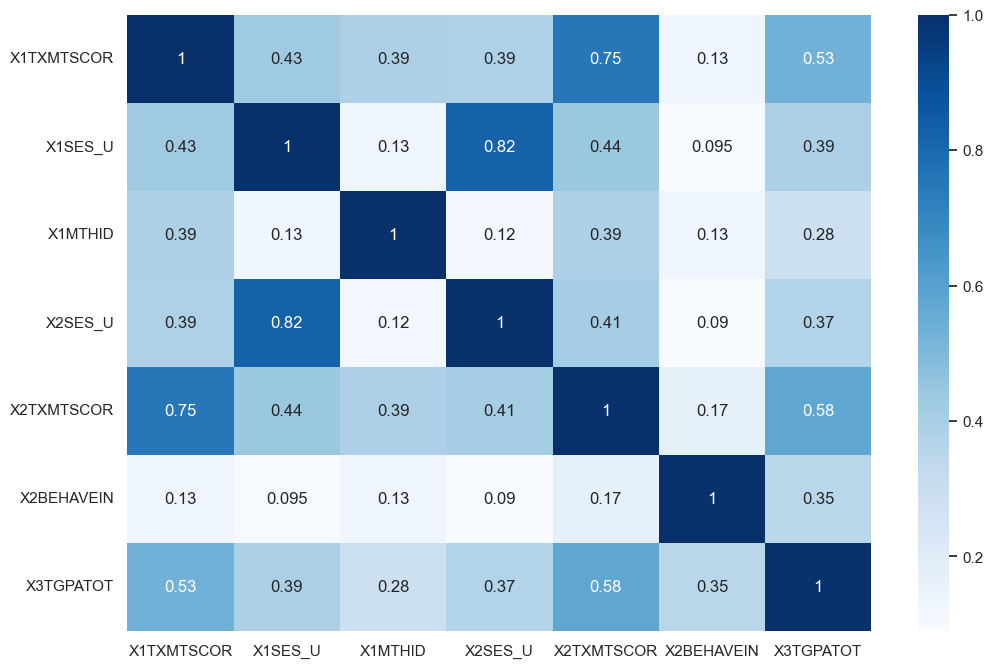

In [154]:
# Heatmap for Correlation
school_corr = df[['X1TXMTSCOR', 'X1SES_U', 'X1MTHID', 'X1PAREDEXPCT', 'X2SES_U', 'X2STUEDEXPCT', 'X2TXMTSCOR', 'X2BEHAVEIN', 'S1HRWORK', 'S1HRACTIVITY', 'S1GOODGRADES','X3TGPATOT']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(school_corr, cmap="Blues", annot=True)

# Save Plot
plt.savefig('GPA_Heatmap.png', bbox_inches='tight')

# Feature Selection

In [87]:
# Linear Regression with 'for' Loop Feature Selection

lm = LinearRegression()
lm.fit(X_train, y_train)
print("Train R-squared:", lm.score(X_train, y_train))
print("Test R-squared:", lm.score(X_test, y_test))

cross_val = KFold(n_splits=10, random_state=None, shuffle=False)
lin_CV_scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=cross_val)
all_vars_cv = np.mean(np.abs(lin_CV_scores))
print("CV Error:", all_vars_cv, '\n')

# Creating lists of number of features and of CV scores, for graphing based on number of predictors
n_features = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]
cv_scores = []

# Run Sequential Feature Selection
start = time.time()

for i in n_features:
    sfs = SequentialFeatureSelector(lm, n_features_to_select = i, direction='forward', 
                                scoring='neg_mean_squared_error', cv=10)
    sfs.fit(X_train, y_train)
    X_train_sel = sfs.transform(X_train)
    X_test_sel = sfs.transform(X_test)
    lm_sel = LinearRegression()
    lm_sel.fit(X_train_sel, y_train)
    lin_CV_scores = cross_val_score(lm_sel, X_train_sel, y_train, scoring='neg_mean_squared_error', cv=cross_val)
    cv_error = np.mean(np.abs(lin_CV_scores))
    cv_scores.append(cv_error)
    print(i, "Features:")
    print("     Train R-squared =", lm_sel.score(X_train_sel, y_train))
    print("     Test R-squared =", lm_sel.score(X_test_sel, y_test))
    print("            CV Error =", cv_error)
    
n_features.append(len(X_train.columns))
cv_scores.append(all_vars_cv)
computation_time = (time.time()-start)
print('\nTime:', computation_time, 'seconds')

Train R-squared: 0.5845526657582052
Test R-squared: 0.5685778295475064
CV Error: 0.27486531169694894 

5 Features:
     Train R-squared = 0.48160268530211336
     Test R-squared = 0.4751619897766154
            CV Error = 0.3313622314400406
10 Features:
     Train R-squared = 0.5294468170595772
     Test R-squared = 0.5195419562684375
            CV Error = 0.3011063821655938
15 Features:
     Train R-squared = 0.545418466477426
     Test R-squared = 0.534873975190636
            CV Error = 0.29110587136407035
20 Features:
     Train R-squared = 0.5545351198128854
     Test R-squared = 0.5422075004700511
            CV Error = 0.28551789919491605
25 Features:
     Train R-squared = 0.5614361879975744
     Test R-squared = 0.5472057109897609
            CV Error = 0.28134769767931433
30 Features:
     Train R-squared = 0.566301204467412
     Test R-squared = 0.5513516712608516
            CV Error = 0.2785418231044029
35 Features:
     Train R-squared = 0.5699813963088797
     Test R-sq

The number of features with the lowest CV Error is 70

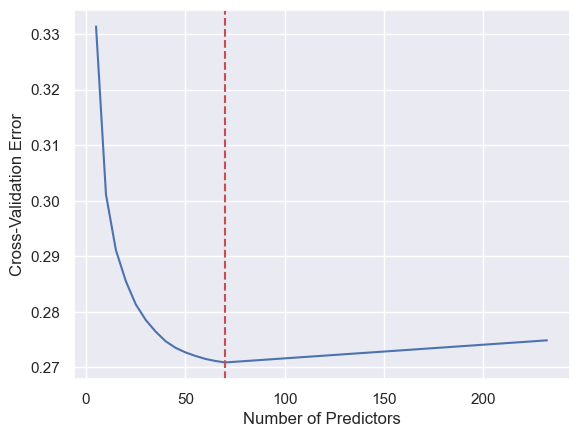

<Figure size 640x480 with 0 Axes>

In [147]:
# Plot CV Error vs Number of Predictors to get best number of predictors to use
plt.plot(n_features, cv_scores)
plt.xlabel('Number of Predictors')
plt.ylabel('Cross-Validation Error')
plt.axvline(x=70, color='r', linestyle='--')
plt.show()

# Save Plot
plt.savefig('N_Predictors_vs_CVError.png', bbox_inches='tight')

### Linear Regression

In [155]:
# Test Linear Regression with 70 selected
lm = LinearRegression()
lm.fit(X_train, y_train)
sfs = SequentialFeatureSelector(lm, n_features_to_select = 70, direction='forward', 
                                scoring='neg_mean_squared_error', cv=10)
sfs.fit(X_train, y_train)

# Save train and test X dataframes with selected features
X_train_sel = sfs.transform(X_train)
X_test_sel = sfs.transform(X_test)

# Test and report results of selected features
lm = LinearRegression()
lm.fit(X_train_sel, y_train)

# Scoring Model
lin_R2_train = lm.score(X_train_sel, y_train)
lin_R2_test = lm.score(X_test_sel, y_test)
lin_CV_error = np.mean(np.abs(cross_val_score(lm, X_train_sel, y_train, 
                                              scoring='neg_mean_squared_error', cv=cross_val)))
y_pred_lm = lm.predict(X_test_sel)
lin_mse = mean_squared_error(y_test, y_pred_lm)

print("Linear Regression Train R-squared:", lin_R2_train)
print("Linear Regression Test R-squared:", lin_R2_test)
print("Linear Regression CV Error:", lin_CV_error)
print("Linear Regression MSE:", lin_mse)

feature_names = np.array(X_train.columns)
vars_tokeep = feature_names[sfs.get_support()]

Linear Regression Train R-squared: 0.5800220977830961
Linear Regression Test R-squared: 0.5657159582296631
Linear Regression CV Error: 0.2708854887810503
Linear Regression MSE: 0.26659968608269485


### Ridge Regression

In [91]:
# The CV version of Ridge is used because it already performs cross validation and gets the best alpha value exactly.

# Fit Model
ridge_cv = RidgeCV(scoring='r2').fit(X_train, y_train)

# Get CV_error
print('Ridge Model Results')
ridge_CV_error = -np.mean(cross_val_score(ridge_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=cross_val))
print("CV Error:", ridge_CV_error)

# Model Score and Best Alpha
ridge_R2_train = np.abs(ridge_cv.best_score_)
print("Best Score (Train R_squared):", ridge_R2_train)
print("Best Alpha:", ridge_cv.alpha_)

# Test Ridge Model
y_pred_ridge = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("Ridge MSE:", ridge_mse)

Ridge Model Results
CV Error: 0.27398457614542415
Best Score (Train R_squared): 0.5706174975751889
Best Alpha: 10.0
Ridge MSE: 0.26442357377085507


### Lasso Regression

In [92]:
lassoCV = LassoCV(cv=10).fit(X_train, y_train)
cross_val = KFold(n_splits=10, random_state=None, shuffle=False)
lasso_R2_train = np.abs(lassoCV.score(X_train, y_train))

print("Lasso - R-squared:", lasso_R2_train)
lassoCV.n_features_in_

lasso_CV_error = -np.mean(cross_val_score(lassoCV, X_train, y_train, scoring='neg_mean_squared_error', cv=cross_val))
print("CV Error:", lasso_CV_error)

# Test Lasso Model
y_pred_lasso = lassoCV.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("Lasso MSE:", lasso_mse)

Lasso - R-squared: 0.5773155500075631
CV Error: 0.27463720587384305
Lasso MSE: 0.2659979852616362


### Random Forest Regression

In [93]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
r2 = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')

print("Train R^2 of %0.2f, with a standard deviation of %0.2f" % (r2.mean(), r2.std()))
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Train CV Error (MSE) of %0.4f, \nStandard deviation of %0.4f" % (np.mean(abs(cv_scores)), np.std(abs(cv_scores))))
print("-------------------------------------------")
print("Test R^2 of %0.2f" % (rf.score(X_test,y_test)))

print("Test MSE of %0.4f" % (mean_squared_error(y_test,rf.predict(X_test))))

Train R^2 of 0.59, with a standard deviation of 0.01
Train CV Error (MSE) of 0.2618, 
Standard deviation of 0.0089
-------------------------------------------
Test R^2 of 0.59
Test MSE of 0.2497


In [99]:
# Random Forest Tuning using GridSearchCV
tuned_parameters = {'n_estimators': [400,500,600], 
                    'max_features': ('sqrt','log2')}
rfr_tuned = GridSearchCV(RandomForestRegressor(random_state=1), tuned_parameters, cv=10,n_jobs=-1, verbose=1)
rfr_tuned.fit(X_train_sel, y_train)

cv_scores = cross_val_score(rfr_tuned, X_train_sel, y_train, cv=10, 
                            scoring='neg_mean_squared_error')
rf_CV_error = np.mean(abs(cv_scores))
rf_R2_train = rfr_tuned.score(X_train_sel, y_train)
rf_R2_test = rfr_tuned.score(X_test_sel, y_test)
y_pred_rfr = rfr_tuned.predict(X_test_sel)
rf_mse = mean_squared_error(y_test, y_pred_rfr)

print("------ Best Parameters  ----------")
print(rfr_tuned.best_params_)
print("------ Best Model Train R^2  ----------")
print(rf_R2_train)
print("------ Best Model Test R^2 ----------")
print(rf_R2_test)
print("-------- Best Model MSE -----------")
print(rf_mse)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
------ Best Parameters  ----------
{'max_features': 'sqrt', 'n_estimators': 500}
------ Best Model Train R^2  ----------
0.9456941197849136
------ Best Model Test R^2 ----------
0.6010546229702802
-------- Best Model MSE -----------
0.2449058727709629


In [156]:
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=seed)
rf.fit(X_train_sel, y_train)
rf_pred = rf.predict(X_test_sel)
rf_R2_train = cross_val_score(rf, X_train_sel, y_train, cv=10, scoring='r2').mean()
rf_R2_test = rf.score(X_test_sel, y_test)
rf_mse = mean_squared_error(y_test, rf_pred)

print("Train R^2:", rf_R2_train)
cv_scores = cross_val_score(rf, X_train_sel, y_train, cv=10, scoring='neg_mean_squared_error')
rf_CV_error = np.mean(abs(cv_scores))
print("Train CV Error (MSE):", rf_CV_error)
print("Test R^2:", rf_R2_test)

print("Test MSE:", rf_mse)

Train R^2: 0.5997593282501565
Train CV Error (MSE): 0.25527616861033176
Test R^2: 0.6001293281061582
Test MSE: 0.2454738957618683


In [103]:
# Create a dataframe of metrics for each model to compare
pred_model_results = pd.DataFrame({'CV Error': [lin_CV_error, ridge_CV_error, lasso_CV_error, rf_CV_error], 
                                   'R_squared': [lin_R2_train, ridge_R2_train, lasso_R2_train, rf_R2_train],
                                  'MSE': [lin_mse, ridge_mse, lasso_mse, rf_mse]}, 
                                  index = ['Linear', 'Ridge', 'Lasso', 'Random Forest'])
pred_model_results

,CV Error,R_squared,MSE
Linear,0.270885,0.580022,0.266600
Ridge,0.273985,0.570617,0.264424
Lasso,0.274637,0.577316,0.265998
Random Forest,0.255276,0.599759,0.245474


# The best prediction model is the Random Forest Regression, with the lowest CV Error, Lowest MSE, and highest R_squared value

C:\Users\mattw\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  del sys.path[0]
C:\Users\mattw\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  


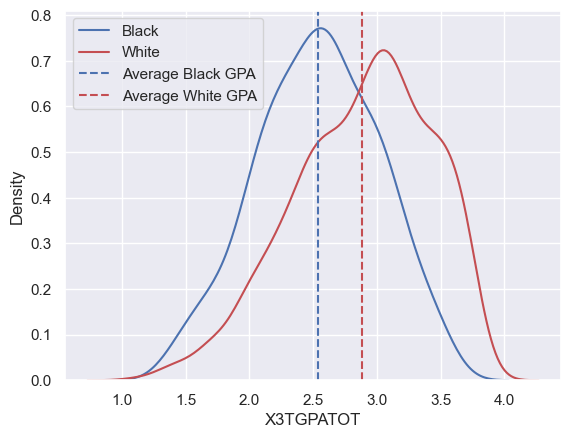

In [157]:
# Distribution Plot 
sns.set(style="darkgrid")
rf_pred = pd.DataFrame(rf_pred, columns = ['X3TGPATOT'])
X_test_sel = pd.DataFrame(X_test_sel, columns=vars_tokeep)

dist_df = pd.concat([rf_pred,X_test_sel], axis=1)

# Generate GPA lists by race
gpa_black = dist_df[dist_df['X1RACE_3']==1]['X3TGPATOT']
gpa_white = dist_df[dist_df['X1RACE_8']==1]['X3TGPATOT']

# plotting both distibutions on the same figure
fig = sns.kdeplot(gpa_black, shade=False, color="b", label='Black')
fig = sns.kdeplot(gpa_white, shade=False, color="r", label='White')

# Add lines to show mean GPA for both races
plt.axvline(x=gpa_black.mean(), color='b', linestyle='--', label = 'Average Black GPA')
plt.axvline(x=gpa_white.mean(), color='r', linestyle='--', label = 'Average White GPA')

plt.legend()
plt.xlabel('X3TGPATOT')
plt.show()

In [145]:
# Save Plot
plt.savefig('GPA_DIST_PLOT.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>